In [36]:
%pylab inline

import sys
import os.path as op
import shutil
# sys.path.insert(0, "/home/mjirik/projects/pyseg_base/")
sys.path.insert(0, op.abspath("../"))
import scipy
import time
import pandas as pd

from imcut import pycut
import sed3
import itertools

latex_dir = "../../papers/iwcia18/"







Populating the interactive namespace from numpy and matplotlib


/storage/plzen1/home/mjirik/miniconda/lib/python3.6/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['copy']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [2]:
%pwd

'/auto/plzen1/home/mjirik/projects/imcut/examples'

## Methods setup

In [6]:
# block size bylo 10
segparams0 = {
    'method':'graphcut',
#     'method':'multiscale_graphcut',
    'use_boundary_penalties': True,
    'boundary_dilatation_distance': 2,
    'boundary_penalties_weight': 1,
    'block_size': 10,
    'tile_zoom_constant': 1
    }

segparams1 = {
    # 'method':'graphcut',
    'method':'multiscale_graphcut_hi2lo',
    'use_boundary_penalties': True,
    'boundary_dilatation_distance': 2,
    'boundary_penalties_weight': 1,
    'block_size': 10,
    'tile_zoom_constant': 1
    }

segparams2 = {
    # 'method':'graphcut',
    'method':'multiscale_graphcut_lo2hi',
    'use_boundary_penalties': True,
    'boundary_dilatation_distance': 2,
    'boundary_penalties_weight': 1,
    'block_size': 10,
    'tile_zoom_constant': 1
    }


labels = [
    "ssgc ",
    "msgc_hi2lo ",
    "msgc_lo2hi ",
]



# Data screenshots

/storage/plzen1/home/mjirik/miniconda/lib/python3.6/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/storage/plzen1/home/mjirik/miniconda/lib/python3.6/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


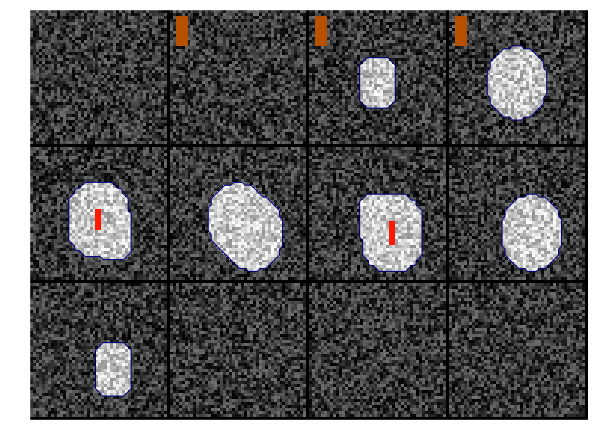

In [3]:

img, seg, seeds = make_data(45, 3, 10, 3)
plt.figure(figsize=(10,15))
import copy
imgview = copy.copy(img)
imgview[:,:,-1] = 0
imgview[:,-1,:] = 0
imgview[-1,:,:] = 0
sed3.show_slices(imgview, contour=seg, seeds=seeds, show=False, slice_step=3.9)
plt.axis("off")
plt.savefig("../graphics/exp062-imgsample_separated.png")

/storage/plzen1/home/mjirik/miniconda/lib/python3.6/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.minimum.reduce will be axis=0, not the current None, to match np.minimum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)
/storage/plzen1/home/mjirik/miniconda/lib/python3.6/site-packages/numpy/ma/core.py:6385: MaskedArrayFutureWarning: In the future the default for ma.maximum.reduce will be axis=0, not the current None, to match np.maximum.reduce. Explicitly pass 0 or None to silence this warning.
  return self.reduce(a)


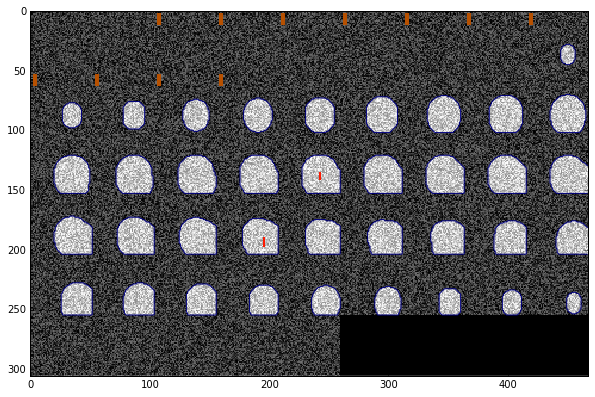

In [4]:

img, seg, seeds = make_data(50, 10, 15)
plt.figure(figsize=(10,15))
sed3.show_slices(img, contour=seg, seeds=seeds)

In [5]:
np.unique(seeds)

array([0, 1, 2], dtype=int8)

In [ ]:
def make_data(sz=32, offset=0, radius=7, seedsz=3):
    #seedsz= int(sz/10)
    space=2
    seeds = np.zeros([sz, sz+1, sz+2], dtype=np.int8)
    xmin = radius + seedsz + offset + 2
    ymin = radius + seedsz + offset + 6
    seeds[offset + 12, xmin + 3:xmin + 7 + seedsz, ymin:ymin+2] = 1
    seeds[offset + 20, xmin + 7:xmin + 12 + seedsz, ymin+5:ymin+7] = 1
    img = np.ones([sz, sz+1, sz+2])
    img = img - seeds

    seeds[
        2:10 + seedsz, 
        2:9+ seedsz, 
        2:3+ seedsz] = 2
    img = scipy.ndimage.morphology.distance_transform_edt(img)
    segm = img < radius
    img = (100 * segm + 80 * np.random.random(img.shape)).astype(np.uint8)
    return img, segm, seeds


### LaTeX export functions

In [29]:
def to_latex_file(df, fn):
    with open(fn, "w") as f:
        f.write(df.to_latex())
        
def latex_float(f, precision=4):
    float_str = "{0:." + str(int(precision)) + "g}"
    float_str = float_str.format(f)
    if "e" in float_str:
        base, exponent = float_str.split("e")
        return r"{0} \times 10^{{{1}}}".format(base, int(exponent))
    else:
        return float_str
    
def float_to_latex_file(fl, fn, precision=4):
    string = latex_float(fl, precision=precision)
    with open(fn, "w") as f:
        f.write(string)

def num2latex(num, filename=None, precision=4):
    if type(num) is str:
        float_str = num
    else:
        float_str = "{0:." + str(int(precision)) + "g}"
        float_str = float_str.format(num)
        
    if float_str[:4] == r"\num":
        pass
    else:
        float_str = "\\num{" + float_str + "}" 
    if filename is not None:
        with open(filename, "w") as f:
            f.write(float_str)
    return float_str

## Umělá data, opakovaný experiment

In [7]:
def process_gc_stats(stats1, prefix=None):
    if prefix is None:
        prefix = ""
    
        
    outstats = {}
    for key in stats1:
        outstats[prefix + key] = stats1[key]
        
    outstats[prefix + "nlinks number"] = np.sum(np.asarray(outstats[prefix + "nlinks shape"]), axis=0)[0]
    outstats[prefix + "tlinks number"] = np.sum(np.asarray(outstats[prefix + "tlinks shape"]), axis=0)[0]
    outstats.pop(prefix + "tlinks shape")
    outstats.pop(prefix + "nlinks shape")
    outstats[prefix + "edge number"] = outstats[prefix + "nlinks number"] + outstats[prefix + "tlinks number"]
#     if stats
#     output_stats1[prefix + 'nlinks number 0'] = stats1['nlinks shape'][0][0]
#     output_stats1[prefix + 'nlinks number 1'] = stats1['nlinks shape'][1][0]
#     output_stats1[prefix + 'nlinks shape'] = None 
#     output_stats1[prefix + 'nlinks number'] = stats1['nlinks number 0'] + stats1['nlinks number 1']

#     output_stats1[prefix + 'tlinks number 0'] = stats1['tlinks shape'][0][0]
#     output_stats1[prefix + 'tlinks number 1'] = stats1['tlinks shape'][1][0]
#     output_stats1[prefix + 'tlinks shape'] = None 
#     output_stats1[prefix + 'tlinks number'] = stats1['tlinks number 0'] + stats1['tlinks number 1']
#     output_stats1[prefix + 'gc time'] = stats1["gc time"] 
#     output_stats1[prefix + '_create_nlinks time'] = stats1['_create_nlinks time']
    return outstats
    
# def process_ssgc_stats(stats0, output_stats1, prefix=None):
#     if prefix is None:
#         prefix = ""
#     output_stats1[prefix + 'tlinks number'] = stats0['tlinks shape'][0][0]
#     output_stats1[prefix + 'nlinks number'] = stats0['nlinks shape'][0][0]
#     output_stats1[prefix + '_create_nlinks time'] = stats0['_create_nlinks time']
#     output_stats1[prefix + 'gc time'] = stats0['gc time']
#     return output_stats1
    
def merge_stats(stats0, stats1, stats2, labels=None):
    if labels is None:
        labels = [""] * 3
    
   
    stats0 = process_gc_stats(stats0, labels[0])
    stats1 = process_gc_stats(stats1, labels[1])
    stats2 = process_gc_stats(stats2, labels[2])
    stats = {}
    stats.update(stats0)
    stats.update(stats1)
    stats.update(stats2)
#     stats1['nlinks number 0'] = stats1['nlinks shape'][0][0]
#     stats1['nlinks number 1'] = stats1['nlinks shape'][1][0]
#     stats1['nlinks shape'] = None 
#     stats1['nlinks number'] = stats1['nlinks number 0'] + stats1['nlinks number 1']

#     stats1['tlinks number 0'] = stats1['tlinks shape'][0][0]
#     stats1['tlinks number 1'] = stats1['tlinks shape'][1][0]
#     stats1['tlinks shape'] = None 
#     stats1['tlinks number'] = stats1['tlinks number 0'] + stats1['tlinks number 1']


#     stats1['normal tlinks number'] = stats0['tlinks shape'][0][0]
#     stats1['normal nlinks number'] = stats0['nlinks shape'][0][0]
#     stats1['normal _create_nlinks time'] = stats0['_create_nlinks time']
#     stats1['normal gc time'] = stats0['gc time']
    
    return stats

def run_gc_with_defined_setup(img, segparams):
    
    start = time.time()
    gc = pycut.ImageGraphCut(img, segparams=segparams)
    gc.set_seeds(seeds)
    gc.run()
    sg1 = gc.segmentation
    stats1 = gc.stats
    elapsed1 = (time.time() - start)
    err1 = np.sum(np.abs(seg - (1 - sg1)))
    stats1["time"] = elapsed1
    stats1["error"] = err1
    return stats1


def add_data_and_algoritm_info(stats, data_params, segparams, start):
    #     stats['msgc time'] = elapsed1
#     stats['normal time'] = elapsed2
    stats['data size'] = data_params[0]
    stats['data offset'] = data_params[1]
    stats['data radius'] = data_params[2]
    stats["block size"] = segparams["block_size"]
    stats["data seedsz"] = data_params[3]
#     stats["GC error"] = err2
#     stats["MSGC error"] = err1
    stats['machine hostname'] = machine_hostname
    stats['experiment iteration start time'] = start
    
    return stats

def add_data_seaborn(stats, data_params, segparams, start, i, label):
    stats = process_gc_stats(stats, "")
    stats = add_data_and_algoritm_info(stats, data_params, segparams, start)
    stats["method"] = label
    dfinew = pd.DataFrame(stats, index=[i*3 + 0])
    #dfnew = dfnew.append(dfinew, sort=True)
    
    return dfinew

In [8]:
# sh 155,160, r10, dpoff 3, seeds 3
dataparams_sh =  range(44, 195, 10)
# dataparams_sh =  range(44, 195, 50)
dp_radius = [10]
dp_offset = [3]
dp_seedsz = [3]

fname = "exp062-multiscale.csv"
fnamenew = "msgc_experiment.csv"


In [9]:
#for par in it:
#    print par


In [10]:
force_rewrite = False
force_rewrite = True

if op.exists(fname) and not force_rewrite:
    df = pd.read_csv(fname)#, index_col=0)
else:
    df = pd.DataFrame([])
    
if op.exists(fnamenew) and not force_rewrite:
    dfnew = pd.read_csv(fnamenew)#, index_col=0)
else:
    dfnew = pd.DataFrame([])


i = 0

import platform
machine_hostname = platform.node()

it = itertools.product(dataparams_sh, dp_offset, dp_radius, dp_seedsz)
for data_params in it:

    start = time.time()
    img, seg, seeds = make_data(data_params[0], data_params[1], data_params[2], data_params[3])
    stats0 = run_gc_with_defined_setup(img, segparams0)
    stats1 = run_gc_with_defined_setup(img, segparams1)
    stats2 = run_gc_with_defined_setup(img, segparams2)

#     stats2 = gc.stats
#     elapsed2 = (time.time() - start)
#     err2 = np.sum(np.abs(seg - (1 - sg2)))
    
    
#     print(err1)
#     print("t1 / t2 =", elapsed1, "/" , elapsed2 ,' = ', elapsed1/elapsed2)
    
    stats = merge_stats(stats0, stats1, stats2, labels)
    
    stats = add_data_and_algoritm_info(stats, data_params, segparams0, start)
#     stats['msgc time'] = elapsed1
#     stats['normal time'] = elapsed2
#     stats['data size'] = data_params[0]
#     stats['data offset'] = data_params[1]
#     stats['data radius'] = data_params[2]
#     stats["block size"] = segparams1["block_size"]
#     stats["data seedsz"] = data_params[3]
# #     stats["GC error"] = err2
# #     stats["MSGC error"] = err1
#     stats['machine hostname'] = machine_hostname
#     stats['start time'] = start
    
    dfi = pd.DataFrame(stats, index=[i])
    
    # display(df)
    df = df.append(dfi, sort=True)
    df.to_csv(fname, index=False)
    
    
    
    
#     stats = process_gc_stats(stats0, "")
    dfinew = add_data_seaborn(stats0, data_params, segparams0, start, i, labels[0])
    dfnew = dfnew.append(dfinew, sort=True)
    dfinew = add_data_seaborn(stats1, data_params, segparams1, start, i, labels[1])
    dfnew = dfnew.append(dfinew, sort=True)
    dfinew = add_data_seaborn(stats2, data_params, segparams2, start, i, labels[2])
    dfnew = dfnew.append(dfinew, sort=True)
    
#     stats = process_gc_stats(stats1, "")
#     stats = add_data_and_algoritm_info(stats, data_params, segparams1, start)
#     dfinew = pd.DataFrame(stats, index=[i*3 + 1])
#     dfnew = dfnew.append(dfinew, sort=True)
    
#     stats = process_gc_stats(stats2, "")
#     stats = add_data_and_algoritm_info(stats, data_params, segparams2, start)
#     dfinew = pd.DataFrame(stats, index=[i*3 + 2])
#     dfnew = dfnew.append(dfinew, sort=True)
    dfnew.to_csv(fnamenew, index=False)
    
    
    
    
    
    i += 1
    

#     plt.figure(figsize=[10,15])
#     sed3.show_slices(img, contour=sg1, seeds=seeds, slice_step=10)
#     plt.figure(figsize=[10,15])
#     sed3.show_slices(img, contour=sg2, seeds=seeds, slice_step=10)

/storage/plzen1/home/mjirik/miniconda/lib/python3.6/site-packages/scipy/ndimage/interpolation.py:583: UserWarning: From scipy 0.13.0, the output shape of zoom() is calculated with round() instead of int() - for these inputs the size of the returned array has changed.
  "the returned array has changed.", UserWarning)


In [11]:
# dfnew.to_csv(fnamenew, index=False)

In [12]:
stats

{'ssgc _create_nlinks time': 2.8270621299743652,
 'ssgc gc time': 36.839988231658936,
 'ssgc time': 42.63242053985596,
 'ssgc error': 0,
 'ssgc nlinks number': 22129966,
 'ssgc tlinks number': 7414680,
 'ssgc edge number': 29544646,
 'msgc_hi2lo t1': 5.435943603515625e-05,
 'msgc_hi2lo _create_nlinks time': 2.2427401542663574,
 'msgc_hi2lo gc time': 1.4425759315490723,
 'msgc_hi2lo t2': 0.31577086448669434,
 'msgc_hi2lo t3': 0.31876349449157715,
 'msgc_hi2lo t4': 1.710291862487793,
 'msgc_hi2lo t5': 3.9987220764160156,
 'msgc_hi2lo t6': 15.357735633850098,
 'msgc_hi2lo t7': 16.65358567237854,
 'msgc_hi2lo t8': 27.953225135803223,
 'msgc_hi2lo t9': 27.981035947799683,
 'msgc_hi2lo time': 29.54975128173828,
 'msgc_hi2lo error': 0,
 'msgc_hi2lo nlinks number': 660585,
 'msgc_hi2lo tlinks number': 220804,
 'msgc_hi2lo edge number': 881389,
 'msgc_lo2hi t1': 0.01116490364074707,
 'msgc_lo2hi _create_nlinks time': 0.003340005874633789,
 'msgc_lo2hi gc time': 1.0303874015808105,
 'msgc_lo2hi 

# Data processing graphs, statistics

In [40]:
df = pd.read_csv(fname)
# df.rename(columns={"msgc time": "MSGC time"})
dfs = df[(df["data seedsz"]==3) & (df["data offset"] == 3) & (df["data radius"] == 10)]
dfs_plus = dfs[dfs['data size'] > 160]

## Old graphs

,ssgc time,msgc_hi2lo time,msgc_lo2hi time,ssgc gc time,msgc_hi2lo gc time,msgc_lo2hi gc time
count,16.000000,16.000000,16.000000,16.000000,16.000000,16.000000
mean,13.868004,11.068857,3.308999,12.091566,1.153019,0.877380
std,13.480098,8.923917,1.721226,11.633443,0.216714,0.122681
min,0.454758,1.559180,1.184974,0.403295,0.713735,0.577411
25%,2.775117,4.042752,2.069698,2.468856,1.034723,0.818119
50%,8.750356,8.374084,2.899261,7.718216,1.171588,0.889934
75%,22.506125,15.954793,4.170554,19.585277,1.269242,0.969076
max,42.632421,29.549751,6.681600,36.839988,1.532725,1.033342


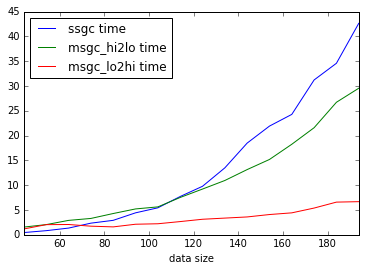

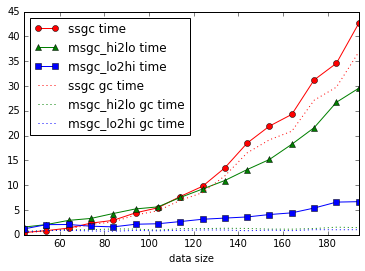

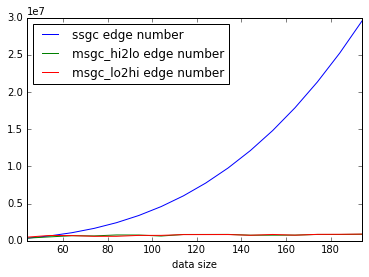

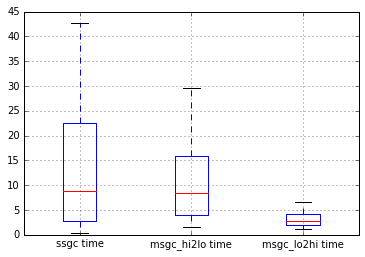

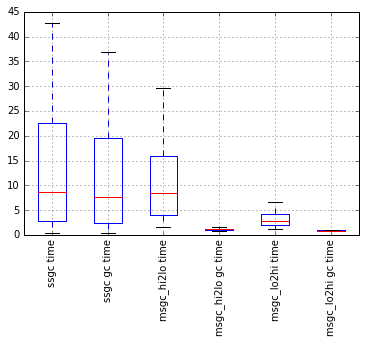

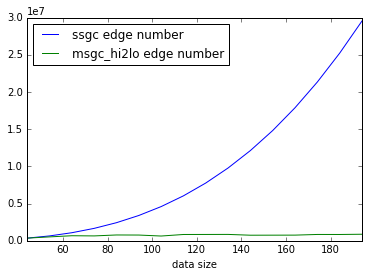

In [13]:

# df["GC total time"] = df["normal time"]
# df["MSGC total time"] = df["msgc time"]
# df["GC time"] = df["normal gc time"]
# df["MSGC time"] = df["gc time"]
# df["MSGC links number"] = df["nlinks number"] + df["tlinks number"]
# df["GC links number"] = df["normal nlinks number"] + df["normal tlinks number"]
# df["time rate"] = df["gc time"] / df["normal gc time"]
# df["MSGC time rate"] = df["gc time"] / df["data size"]
# df["GC time rate"] = df["normal gc time"] / df["data size"]

def func(x, a, c, d):
    return a*np.exp(-c*x)+d

#from scipy.optimize import curve_fit
#popt, pcov = curve_fit(func, df["data size"], df["MSGC time"])
#print popt, pcov

#def msgcp(x):
#    a, c, d = popt
#    return a*np.exp(-c*x)+d
msgcp = np.poly1d(np.polyfit(df["data size"], df[labels[0] + "time"], 2))
df[labels[0] + "time trend"] = msgcp(df["data size"])
msgctp = np.poly1d(np.polyfit(df["data size"], df[labels[1] + "time"], 2))
df[labels[1] + "time trend"] = msgctp(df["data size"])


plt.figure()
df[[labels[0] + 'time', labels[1] + 'time', labels[2] + "time", 'data size']].sort_values("data size").plot(x='data size')
plt.figure(figsize=(10,15))
df[[labels[0] + 'time', labels[1] + 'time', labels[2] + "time",
    labels[0] + 'gc time', labels[1] + 'gc time', labels[2] + "gc time", 'data size',
   ]].sort_values("data size").plot(x='data size', style=["-o", "-^", "-s", ":", ":", ":"], color=["r", "g", "b", "r", "g", "b"])
plt.savefig("../graphics/exp062-msgc_time_size_comparison.pdf")


plt.figure()
#df[['normal nlinks number', "nlinks number", 'data size']].sort("data size").plot(x='data size')
df[[labels[0] + 'edge number', labels[1] + 'edge number', labels[2] + 'edge number', 'data size']].sort_values("data size").plot(
    x='data size')


# plt.figure()
# df[[labels[0] + 'time', labels[1] + "time", labels[1] + "time trend", 'data size']].sort_values("data size").plot(
#     x='data size', style=["-", "x", "-"])
# plt.savefig("../graphics/exp062-multiscale-time-data_size.pdf")
# plt.figure()
# df[['GC total time', "MSGC total time", "MSGC total time trend", 'data size']].sort_values("data size").plot(
#     x='data size', style=["-", "x", "-"])
# plt.savefig("../graphics/exp062-multiscale-total_time-data_size.pdf")

plt.figure()
df[[labels[0] + "time", labels[1] + "time", labels[2] + "time",]].boxplot(showfliers=False)
plt.savefig("../graphics/exp062-multiscale-gc_time.pdf")
plt.figure()
df[[labels[0] + 'time', labels[0] + 'gc time', labels[1] + "time",
    labels[1] + 'gc time', labels[2] + 'time', labels[2] + "gc time",
   
   ]].boxplot(showfliers=False, rot=90)
plt.savefig("../graphics/exp062-multiscale-gc_time-total_time.pdf")
# plt.figure()
# df[["GC total time", "MSGC total time"]].boxplot(showfliers=False)
# plt.savefig("../graphics/exp062-multiscale-total_time.pdf")

# plt.figure()
# df[['MSGC time', "GC links number", 'GC time']].sort_values("GC links number").plot(x='GC links number')



dfs = df[(df["data seedsz"]==3) & (df["data offset"] == 3) & (df["data radius"] == 10)]
# plt.figure()
# dfs[["GC total time", "MSGC total time", 'GC time', 'MSGC time', 'data size']].sort_values("data size").plot(x='data size', style=["-", "-", "--","--"])
# plt.savefig("../graphics/exp062-multiscale-all.pdf")

plt.figure()
dfs[[labels[0] + "edge number", labels[1] + "edge number", 'data size']].sort_values("data size").plot(x='data size', style=["-", "-", "--","--"])
plt.savefig("../graphics/exp062-multiscale-links_number.pdf")

df_mn = df[[labels[0] + "time", labels[1] + "time", labels[2] + "time", labels[0] + "gc time", labels[1] + "gc time", labels[2] + "gc time"]].describe()
display(df_mn)
def to_latex_file(df, fn):
    with open(fn, "w") as f:
        f.write(df.to_latex())
to_latex_file(df_mn, op.abspath("../includes/exp062-all.tex"))

In [41]:
df.keys()

Index(['block size', 'data offset', 'data radius', 'data seedsz', 'data size',
       'experiment iteration start time', 'machine hostname',
       'msgc_hi2lo _create_nlinks time', 'msgc_hi2lo edge number',
       'msgc_hi2lo error', 'msgc_hi2lo gc time', 'msgc_hi2lo nlinks number',
       'msgc_hi2lo t1', 'msgc_hi2lo t2', 'msgc_hi2lo t3', 'msgc_hi2lo t4',
       'msgc_hi2lo t5', 'msgc_hi2lo t6', 'msgc_hi2lo t7', 'msgc_hi2lo t8',
       'msgc_hi2lo t9', 'msgc_hi2lo time', 'msgc_hi2lo tlinks number',
       'msgc_lo2hi _create_nlinks time', 'msgc_lo2hi edge number',
       'msgc_lo2hi error', 'msgc_lo2hi gc time', 'msgc_lo2hi nlinks number',
       'msgc_lo2hi t1', 'msgc_lo2hi t2', 'msgc_lo2hi t3', 'msgc_lo2hi t9',
       'msgc_lo2hi time', 'msgc_lo2hi tlinks number',
       'ssgc _create_nlinks time', 'ssgc edge number', 'ssgc error',
       'ssgc gc time', 'ssgc nlinks number', 'ssgc time',
       'ssgc tlinks number'],
      dtype='object')

# Seaborn graphs

In [46]:
df = pd.read_csv(fnamenew)
# df.rename(columns={"msgc time": "MSGC time"})
dfs = df[(df["data seedsz"]==3) & (df["data offset"] == 3) & (df["data radius"] == 10)]
dfs_plus = dfs[dfs['data size'] > 160]

In [42]:
import seaborn as sns
sns.set_context("paper")
sns.set_style("white")

In [47]:
df.keys()

Index(['_create_nlinks time', 'block size', 'data offset', 'data radius',
       'data seedsz', 'data size', 'edge number', 'error',
       'experiment iteration start time', 'gc time', 'machine hostname',
       'method', 'nlinks number', 't1', 't2', 't3', 't4', 't5', 't6', 't7',
       't8', 't9', 'time', 'tlinks number'],
      dtype='object')

In [34]:


#df

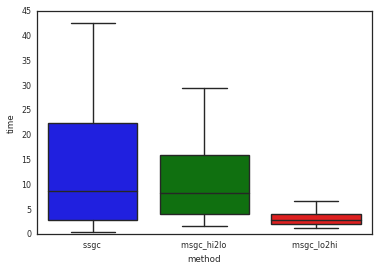

In [48]:
sns.boxplot(data=df, y="time", x="method")

In [56]:
# df

In [50]:

uu = pd.melt(df.rename(columns={"gc time": "gc", "time": "total"}), value_vars=["gc", "total"], id_vars=["method"], var_name="time type", value_name="time")
# uu = pd.melt(dfs, value_vars=["gc time", "time"], id_vars=["method"], var_name="type", value_name="time")
# uu

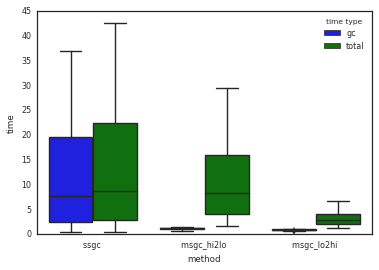

In [51]:
sns.boxplot(data=uu, hue="time type",y="time", x="method")
plt.savefig(op.join(latex_dir, "msgc_time_boxplot.pdf"), dpi=1000)

In [53]:
# sns.boxplot(data=dfs, y="error", x="method")

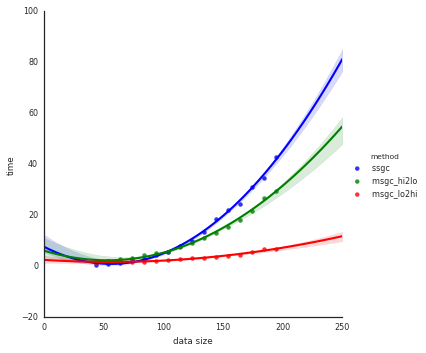

In [21]:
sns.lmplot(data=df, x="data size", y="time", hue="method", order=2)

/storage/plzen1/home/mjirik/miniconda/lib/python3.6/site-packages/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


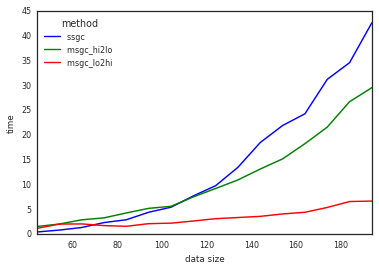

In [57]:
sns.tsplot(data=df, time="data size", value="time", unit="method", condition="method")
plt.savefig(op.join(latex_dir, "msgc_size_time.pdf"), dpi=1000)

In [58]:
# df

In [59]:
# df["method"]

# Statistics

In [38]:
from scipy import stats



dfs_plus_describe = dfs_plus.describe()
display(dfs_plus_describe)

print("pokud je pvalue mensi nez zvolena hladina vyznamnosti (0.01=1%), je vsechno ok")
tt = stats.ttest_rel(dfs_plus.loc[dfs_plus["method"] == "ssgc"]['time'], dfs_plus.loc[dfs_plus["method"] == "msgc_lo2hi"]['time'])
# tt

,_create_nlinks time,block size,data offset,data radius,data seedsz,data size,edge number,error,experiment iteration start time,gc time,...,t2,t3,t4,t5,t6,t7,t8,t9,time,tlinks number
count,12.000000,12.0,12.0,12.0,12.0,12.000000,1.200000e+01,12.000000,1.200000e+01,12.000000,...,8.000000,8.000000,4.000000,4.000000,4.000000,4.000000,4.000000,8.000000,12.000000,1.200000e+01
mean,1.347287,10.0,3.0,10.0,3.0,179.000000,8.395077e+06,34757.666667,1.529003e+09,10.327234,...,0.270897,0.274925,1.326967,3.161154,12.217762,13.377643,22.566895,13.642140,20.992436,2.107114e+06
std,1.061986,0.0,0.0,0.0,0.0,11.677484,1.145975e+07,51420.478238,6.942020e+01,13.971221,...,0.056612,0.059486,0.307747,0.693018,2.679327,2.855975,4.880094,10.104665,12.835595,2.876893e+06
min,0.002533,10.0,3.0,10.0,3.0,164.000000,7.568500e+05,0.000000,1.529002e+09,0.837564,...,0.190678,0.192867,0.997948,2.396526,9.226007,10.165629,17.027050,3.513312,4.425462,1.896460e+05
25%,0.003321,10.0,3.0,10.0,3.0,171.500000,8.517820e+05,0.000000,1.529002e+09,1.032604,...,0.228791,0.231186,1.136470,2.735895,10.540345,11.570070,19.423037,5.168449,6.658513,2.131628e+05
50%,1.652277,10.0,3.0,10.0,3.0,179.000000,8.771325e+05,0.500000,1.529003e+09,1.354465,...,0.268438,0.271043,1.299814,3.124685,12.143654,13.345679,22.643653,11.288172,22.932538,2.196585e+05
75%,2.112264,10.0,3.0,10.0,3.0,186.500000,1.875086e+07,98768.000000,1.529003e+09,22.446705,...,0.315771,0.318617,1.490310,3.549944,13.821071,15.153251,25.787512,21.452001,29.966827,4.708770e+06
max,2.827062,10.0,3.0,10.0,3.0,194.000000,2.954465e+07,107028.000000,1.529003e+09,36.839988,...,0.357749,0.372103,1.710292,3.998722,15.357736,16.653586,27.953225,27.981036,42.632421,7.414680e+06


pokud je pvalue mensi nez zvolena hladina vyznamnosti (0.01=1%), je vsechno ok


In [61]:
ssgc_rows = dfs_plus[dfs_plus["method"].str.contains(labels[0])]
ssgc_hi2lo_rows = dfs_plus[dfs_plus["method"].str.contains(labels[1])]
ssgc_lo2hi_rows = dfs_plus[dfs_plus["method"].str.contains(labels[2])]
pp0 = stats.ttest_rel(ssgc_rows["time"], ssgc_hi2lo_rows["time"])
pp1 = stats.ttest_rel(ssgc_rows["time"], ssgc_lo2hi_rows["time"])
pp2 = stats.ttest_rel(ssgc_hi2lo_rows["time"], ssgc_lo2hi_rows["time"])

print("pokud je pvalue mensi nez zvolena hladina vyznamnosti (0.01=1%), je vsechno ok") 
#mozna staci i dvojnasobek hladiny vyzamnosi
print("statistic musi byt vetsi nez 0")
display(pp0)
display(pp1)
display(pp2)

float_to_latex_file(pp0.pvalue, op.join(latex_dir, "ttest_pvalue_ssgc_msgc_hi2lo.tex"))
float_to_latex_file(pp1.pvalue, op.join(latex_dir, "ttest_pvalue_ssgc_msgc_lo2hi.tex"))
float_to_latex_file(pp2.pvalue, op.join(latex_dir, "ttest_pvalue_msgc_hi2lo_msgc_lo2hi.tex"))




pokud je pvalue mensi nez zvolena hladina vyznamnosti (0.01=1%), je vsechno ok
statistic musi byt vetsi nez 0


Ttest_relResult(statistic=6.0839850456848623, pvalue=0.0089166462328127572)

Ttest_relResult(statistic=8.2329306079499052, pvalue=0.0037515350436766602)

Ttest_relResult(statistic=9.067906192785923, pvalue=0.0028330564618168513)

In [27]:
dfs_plus["method"] == "ssgc "

36     True
37    False
38    False
39     True
40    False
41    False
42     True
43    False
44    False
45     True
46    False
47    False
Name: method, dtype: bool

In [ ]:
df_mn = df[["GC total time", "MSGC total time", "GC time", "MSGC time"]].describe()
display(df_mn)
to_latex_file(df_mn, "../includes/exp062-all2data_size.tex")

dfs_mn = dfs[["GC total time", "MSGC total time", "GC time", "MSGC time"]].describe()
display(dfs_mn)
to_latex_file(dfs_mn, "../includes/exp062-selection2data_size.tex")